<a href="https://colab.research.google.com/github/psyduck1203/Hands-on-ML-Basic-to-Advance-/blob/master/Sentiment%20analysis%20for%20depression%20based%20on%20social%20media%20posts/Model/Depression_detection_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
tweets = pd.read_csv('/content/sentiment_tweets3.csv')
tweets.head(20)

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [3]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)


In [4]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


As you can see, I used almost all the data for training: 98% and the rest for testing.

In [6]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [8]:
trainData['label'].value_counts()

0    7840
1    2267
Name: label, dtype: int64

In [9]:
trainData.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [10]:
testData['label'].value_counts()

0    160
1     47
Name: label, dtype: int64

In [11]:
testData.head()

,message,label
7,23 or 24ï¿½C possible today. Nice,0
46,@rowanberry ohhh sending loads of Positive vi...,0
49,@cosmicgirlie Thinking of you. Everything cros...,0
84,Just a simple girl..oatmeal makes me really ha...,0
86,"@aplusk thats beautiful, what a lovely thing t...",0


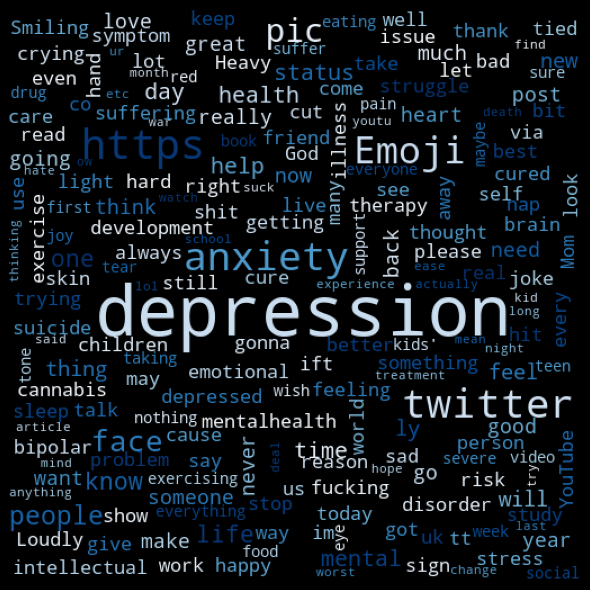

In [12]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

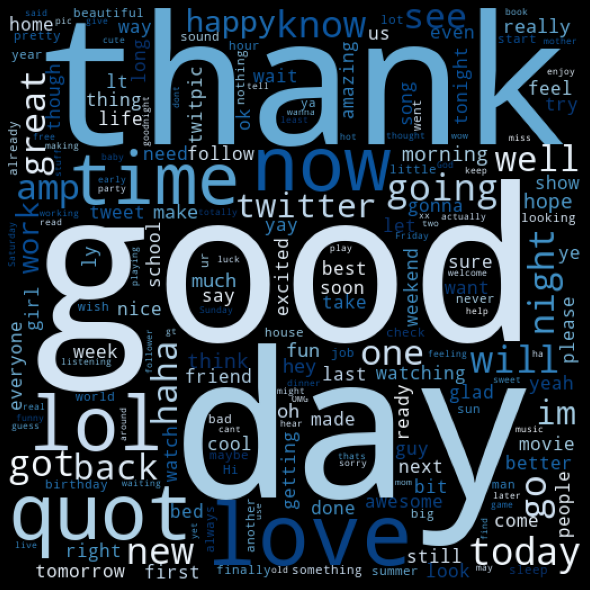

In [13]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [14]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [15]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [16]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [17]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.8461538461538461
Recall:  0.46808510638297873
F-score:  0.6027397260273972
Accuracy:  0.8599033816425121


In [18]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.9
Recall:  0.19148936170212766
F-score:  0.3157894736842105
Accuracy:  0.8115942028985508


In [19]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [20]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)


True

In [21]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

True

In [22]:
pm = process_message('I am officially done with @kanyewest')
sc_tf_idf.classify(pm)


True

In [23]:
pm = process_message('Feeling down...')
sc_tf_idf.classify(pm)


True

In [24]:
pm = process_message('My depression will not let me work out')
sc_tf_idf.classify(pm)


True

In [25]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_tf_idf.classify(pm)


False

In [26]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)


False

In [27]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_tf_idf.classify(pm)

False

In [28]:
pm = process_message('It’s the little things that make me smile. Got our new car today and this arrived with it')
sc_tf_idf.classify(pm)

False

In [29]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [30]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

True

In [31]:
pm = process_message('Feeling down...')
sc_bow.classify(pm)

False

In [32]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

False

In [33]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

False

In [34]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_bow.classify(pm)

False